In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import findspark
findspark.init("/home/rajdeep/spark-3.5.0-bin-hadoop3/")

In [3]:
from pyspark.sql import SparkSession

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#initalizing the spark object
spark = SparkSession.builder.appName("seeds").getOrCreate()

In [7]:
#reading the data into dataframe
df = spark.read.csv("data/seeds_dataset.csv", inferSchema=True, header=True)

In [56]:
df.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|             4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|             5.175|
|14.38|    14.21|     0.8951|             5.386|             3.312|   2.4619999999999997|             4.956|
|14.69|    14.49|  

In [57]:
df.describe().show()

+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|summary|              area|         perimeter|         compactness|   length_of_kernel|   width_of_kernel|asymmetry_coefficient|   length_of_groove|
+-------+------------------+------------------+--------------------+-------------------+------------------+---------------------+-------------------+
|  count|               210|               210|                 210|                210|               210|                  210|                210|
|   mean|14.847523809523816|14.559285714285718|  0.8709985714285714|  5.628533333333335| 3.258604761904762|   3.7001999999999997|  5.408071428571429|
| stddev|2.9096994306873647|1.3059587265640225|0.023629416583846364|0.44306347772644983|0.3777144449065867|   1.5035589702547392|0.49148049910240543|
|    min|             10.59|             12.41|              0.8081|              4.899|            

In [58]:
df.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

In [9]:
#initializing the VectorAssembler to create feature vector for ML model
assembler = VectorAssembler(inputCols=df.columns, outputCol='feature')

In [10]:
#creating the new column with vector of required row data
df = assembler.transform(df)

In [11]:
#initializing the StandardScaler so as all the feature are in same range
scaler = StandardScaler(inputCol='feature',outputCol='feature_scaled')
#creating the new column with scaled vector of required row data
df = scaler.fit(df).transform(df)

In [12]:
#finding elbow to find optimal value of cluster
cost = np.zeros(10)

for k in range(2,10):
    kmean = KMeans(featuresCol='feature_scaled', seed=1).setK(k)
    model = kmean.fit(df)
    cost[k] = model.summary.trainingCost

cost_df = pd.DataFrame(cost[2:])
cost_df.columns = ['cost']
new_col = [i for i in range(2,10)]
cost_df.insert(0,'cluster',new_col)

23/12/01 18:13:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


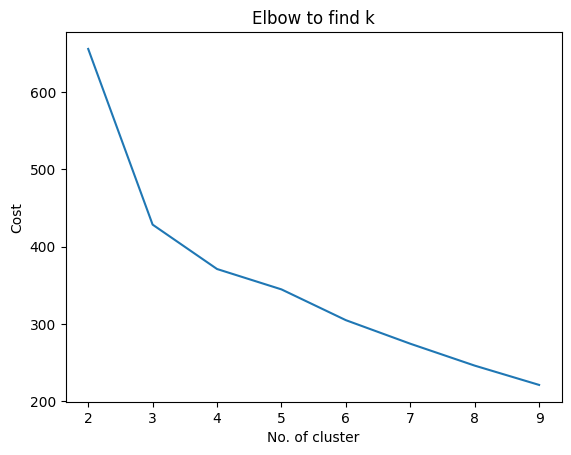

In [13]:
#plotting the WCSS value
plt.plot(cost_df['cluster'],cost_df['cost'])
plt.xlabel('No. of cluster')
plt.ylabel('Cost')
plt.title('Elbow to find k')
plt.show()

In [14]:
#initializing the model as well fitting and predicting the value
kmeans = KMeans(k=3,seed=1,featuresCol='feature_scaled')
model = kmeans.fit(df)
df = model.transform(df)

In [18]:
#Evaluating the cluster by computting the within sum-set of squared errors
model.summary.trainingCost

428.6082011872446

In [15]:
#printing the centre of k clusters
centers = model.clusterCenters() 
print("Cluster Centers: ") 
for center in centers: 
    print(center)

Cluster Centers: 
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]


In [69]:
df.show()

+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+--------------------+----------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|  length_of_groove|             feature|      feature_scaled|prediction|
+-----+---------+-----------+------------------+------------------+---------------------+------------------+--------------------+--------------------+----------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|              5.22|[15.26,14.84,0.87...|[5.24452795332028...|         0|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|             4.956|[14.88,14.57,0.88...|[5.11393027165175...|         0|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|             4.825|[14.29,14.09,0.90...|[4.91116018695588...|         0|
|13.84|    13.94|     0.8955

In [68]:
df.select(['prediction']).show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         2|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
+----------+
only showing top 20 rows

